In [45]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
fake_news_path = ("/content/drive/MyDrive/Internship/fake-and-real-news-dataset/Fake.csv")
true_news_path = ("/content/drive/MyDrive/Internship/fake-and-real-news-dataset/True.csv")

In [48]:
df_fake_original = pd.read_csv(fake_news_path)
df_fake_original.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [49]:
df_true_original= pd.read_csv(true_news_path)
df_true_original.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [50]:
df_fake = df_fake_original.copy()
df_true = df_true_original.copy()

In [51]:
print(df_fake.shape)
print(df_true.shape)

(23481, 4)
(21417, 4)


In [52]:
df_fake.info(),  df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


(None, None)

In [53]:
df_fake.drop(['title', 'subject', 'date'], axis=1, inplace=True)
df_true.drop(['title', 'subject', 'date'], axis=1, inplace=True)

In [54]:
df_fake['target']=0
df_true['target']=1

In [55]:
df = pd.concat([df_fake,df_true], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head(10)

,text,target
0,"21st Century Wire says Ben Stein, reputable pr...",0
1,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,"On Monday, Donald Trump once again embarrassed...",0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1
5,"On Wednesday, Democrats took a powerful stance...",0
6,President Trump s rally in FL on Saturday was ...,0
7,He s been Europe s version of the outspoken Te...,0
8,WASHINGTON (Reuters) - The State Department sa...,1
9,(This version of the story corrects the figur...,1


In [56]:
print(df.shape)
print(df.columns)

(44898, 2)
Index(['text', 'target'], dtype='object')


In [57]:
df.target.value_counts()

,count
target,
0,23481
1,21417


# Text Preprocessing

In [58]:
df['text'][37]

"Hillary Clinton is bending over backwards to convince American voters that Donald Trump is a  racist  because a White Supremacist and a KKK member said they plan to vote for him. ]who eulogized KKK leader, mentor and close friend, Robert C. Byrd, and about the $20,000 donation she accepted from the KKK just this year!?  Here s a tweet from the woman who REFUSES to speak to reporters after being caught in yet ANOTHER SCANDAL. This time, its been revealed that Hillary and her grifter and serial rapist husband have been selling our nation for favors through their pay-to-play slush fund, the Clinton Foundation (Criminal Piggy Bank). Oh yeah about that tweet:It's not a coincidence that white supremacists proudly support Trump. pic.twitter.com/3OX4I1GSkr  Hillary Clinton (@HillaryClinton) August 25, 2016Hillary Clinton s presidential campaign has received more than $20,000 in donations contributed by members of the Ku Klux Klan, a prominent member of the hate group said Monday.Mr. Quigg, th

In [59]:
# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    words = [stemmer.stem(word) for word in words]  # Apply stemming
    words = [lemmatizer.lemmatize(word) for word in words]  # Apply lemmatization

    return " ".join(words)

df['text'] = df['text'].apply(preprocess_text)
print(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                    text  target
0      centuri wire say ben stein reput professor pep...       0
1      washington reuter u presid donald trump remov ...       1
2      reuter puerto rico governor ricardo rossello s...       1
3      monday donald trump embarrass countri accident...       0
4      glasgow scotland reuter u presidenti candid go...       1
...                                                  ...     ...
44893                                                          0
44894  londontokyo reuter british prime minist theres...       1
44895  berlin reuter chancellor angela merkel said ge...       1
44896  jesu fcking christ presid moron satisfi simpli...       0
44897  toast bigger troubl thought much whole thing g...       0

[44898 rows x 2 columns]


In [60]:
df['text'][37]

'hillari clinton bend backward convinc american voter donald trump racist white supremacist kkk member said plan vote eulog kkk leader mentor close friend robert c byrd donat accept kkk year tweet woman refus speak report caught yet anoth scandal time reveal hillari grifter serial rapist husband sell nation favor paytoplay slush fund clinton foundat crimin piggi bank oh yeah tweetit coincid white supremacist proudli support trump hillari clinton hillaryclinton august clinton presidenti campaign receiv donat contribut member ku klux klan promin member hate group said mondaymr quigg leader klan california chapter announc last month abandon support republican presidenti frontrunn donald trump lieu back like democrat oppon klansman claim member rais mr clinton donat anonym campaignclinton campaign spokesman josh schwerin disput grand dragon claim said former secretari state reject group endors washington timeswatch hillari prais kkk leader senat robert c byrd'

# **Convert into Vectors**

In [61]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(n_features=5000)  # Adjust feature size
X = hv.transform(df['text'])

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5000)  # Adjust feature size
Text = cv.fit_transform(df['text'])

In [63]:
Text_array = Text.toarray()
x = Text_array

In [64]:
x.shape

(44898, 5000)

In [65]:
x[2].max()

np.int64(7)

In [66]:
y= df.iloc[:, -1].values

In [67]:
y.shape

(44898,)

In [68]:
Text.shape

(44898, 5000)

In [69]:
# split the data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [70]:
x_train.shape

(35918, 5000)

In [71]:
x_test.shape

(8980, 5000)

In [72]:
y_test.shape

(8980,)

In [73]:
y_test.shape

(8980,)

In [74]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [75]:
clf1 = GaussianNB()
clf2 = MultinomialNB()
clf3 = BernoulliNB()

In [76]:
clf1.fit(x_train, y_train)

GaussianNB()

In [77]:
clf2.fit(x_train, y_train)

MultinomialNB()

In [78]:
clf3.fit(x_train, y_train)

BernoulliNB()

In [79]:
y_pred1 = clf1.predict(x_train)
y_pred2 = clf2.predict(x_train)
y_pred3 = clf3.predict(x_train)

In [80]:
x_train.shape

(35918, 5000)

In [81]:
y_pred1.shape

(35918,)

In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("GaussianNB", accuracy_score(y_train, y_pred1))
print("MultinomialNB", accuracy_score(y_train, y_pred2))
print("BernoulliNB", accuracy_score(y_train, y_pred3))

GaussianNB 0.8816749262208363
MultinomialNB 0.9455983072554152
BernoulliNB 0.9632496241438833


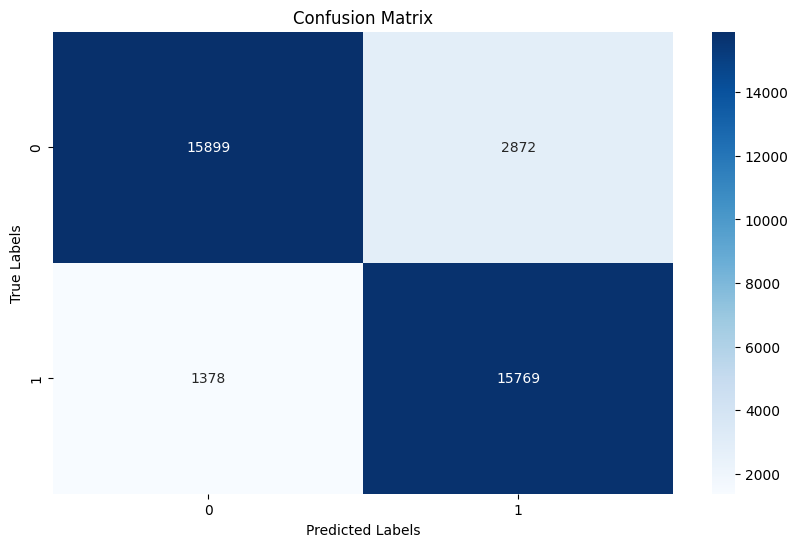

In [83]:
cm = confusion_matrix(y_train, y_pred1)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [85]:
import joblib

# Save the model
joblib.dump(clf2, '/content/drive/MyDrive/Internship/fake_news_model.pkl')

['/content/drive/MyDrive/Internship/fake_news_model.pkl']

In [87]:
# Save the trained CountVectorizer
joblib.dump(cv, '/content/drive/MyDrive/Internship/count_vectorizer.pkl')
print("CountVectorizer saved successfully!")

CountVectorizer saved successfully!


In [96]:
import joblib

# **1. Load the trained model**
loaded_model = joblib.load('/content/drive/MyDrive/Internship/fake_news_model.pkl')

# **2. Load the trained CountVectorizer**
cv = joblib.load('/content/drive/MyDrive/Internship/count_vectorizer.pkl')



In [95]:
# **3. Unseen news sample**
unseen_news = ["Imran Khan was x pm of pakistan"]

# **4. Transform the new data using the saved CountVectorizer**
unseen_news_vectorized = cv.transform(unseen_news).toarray()

# **5. Make predictions**
predictions = loaded_model.predict(unseen_news_vectorized)

# **6. Print Results**
for i, news in enumerate(unseen_news):
    print(f"News: {news}")
    print(f"Prediction: {'Real' if predictions[i] == 1 else 'Fake'}")
    print("-" * 50)


News: Imran Khan was x pm of pakistan
Prediction: Real
--------------------------------------------------


# **WEB APPLICATION**

In [92]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00


In [94]:
import gradio as gr
import joblib

# Load trained model and CountVectorizer
model = joblib.load("/content/drive/MyDrive/Internship/fake_news_model.pkl")
cv = joblib.load("/content/drive/MyDrive/Internship/count_vectorizer.pkl")

# Prediction function
def predict_news(news_text):
    text_vectorized = cv.transform([news_text]).toarray()
    prediction = model.predict(text_vectorized)
    return "Real News" if prediction[0] == 1 else "Fake News"

# Create Gradio Interface
title = "📰 Fake News Detection"
description = "Enter a news article below and the model will predict whether it is Fake or Real."

app = gr.Interface(
    fn=predict_news,
    inputs=gr.Textbox(lines=5, placeholder="Enter news article here..."),
    outputs="text",
    title=title,
    description=description
)

# Launch the Gradio app
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5748a79afaeb596a8f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
